# Guide to Extracting Data w/ APIs from the Whoop Strap 4.0

<img src="https://mygolfspy-wp-uploads.s3.amazonaws.com/uploads/2021/12/whoop-4.0-3.jpeg" width="500"/>



As Kanye once [said](https://www.youtube.com/watch?v=8fbyfDbi-MI),

> Scoop-diddy-whoop
>
> Whoop-diddy-scoop

While we certainly won't be rapping in this notebook, we will be using the [WHOOP 4.0](https://www.whoop.com/membership/strap/), a small wearable that fits onto your wrist as shown above! Featuring a light, discreet wristband that is also waterproof, the WHOOP 4.0 offers comfortable [physical activity](https://github.com/alrojo/wearipedia/tree/main/metrics/physical-activity) and [sleep](https://github.com/alrojo/wearipedia/tree/main/metrics/sleep) tracking with wireless charging and an app with useful calculated metrics such as strain and recovery. 


We've used the WHOOP 4.0 for a while now, and we'll show you how to extract its data, visualize steep stages, and compute correlations and other statistical measures based on your data! While you will need a WHOOP 4.0 set up to actually collect the data, the data *extraction* requires only an internet connection and your username and password.

This is a comprehensive, clear guide to extract your data from the WHOOP 4.0 using an unofficial WHOOP [Application Programming Interface (API)](https://en.wikipedia.org/wiki/API).

If you want to know more about WHOOP 4.0, see the [README](https://github.com/alrojo/wearipedia/tree/main/wearables/whoop-strap-4.0) for a detailed analysis of performances, sensors, data privacy, and extraction pipelines.

We will be able to extract the following parameters:

Parameter Name  | Sampling Frequency 
-------------------|------------------
Average heart rate      |  Daily 
Maximum heart rate |  Daily
Kilojoules (energy burned) |  Daily
Strain score |  Daily
Number of naps |  Daily
Baseline sleep need |  Daily
Sleep debt |  Daily
Sleep need strain (extra sleep required due to strain) |  Daily
Total sleep need (calculated with other values) |  Daily
Sleep quality duration |  Daily
Respiratory rate |  Daily (during core sleep)
Blood oxygen |  Daily (during core sleep)
Resting heart rate  |  Daily (during core sleep)
Heart rate variability |  Daily (during core sleep)
Skin temperature |  Daily (during core sleep)
Heart rate | Every 7 seconds

Note that some of the parameters are for an entire 24-hour period, while others are measured and reported only for the time the user is in a core sleep (contrasted with a nap, the core sleep is the "main" sleep, which usually occurs at night).

<br><br>
In this guide, we sequentially cover the following **five** topics to extract from the WHOOP 4.0 API:
1. **Setup**
2. **Authentication/Authorization**
    - Requires only username and password, no OAuth(2).
3. **Data extraction**
    - You can get data from the API in a couple lines of code.
4. **Data visualization**
    - 4.1: We reproduce a day-by-day week-long plot of hours slept and sleep needed, which is displayed in the mobile app originally. We do this with matplotlib.
    - 4.2: We reproduce a time series plot of heart rate over the course of a day, sampled every 6 seconds, which is shown in the WHOOP app (both the webapp and the mobile app, if you turn the phone sideways). In this plot, we deal with missing data (when the user takes off the device for a long time) and also combine sleep information to color in intervals of the time series where the user is sleeping, allowing you to quickly see how the heart rate responds to sleep.
5. **Data analysis**
    - 5.1: We try to find a correlation between the length of a sleep period and the median heart rate for that sleep period. We find that the correlation is not statistically significant, unless excluding an outlier.
    - 5.2: We try to check whether the median heart rate is correlated to whether the sleep is a nap or a night sleep. We find that for our data this is statistically significant.


Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own email and password on your own Colab instance, you can visualize your own *real* data. That being said, we were unable to thoroughly test the timezone functionality, though, since we only have one account, so beware.

# 1. Setup

## 1.1 Study participant setup and usage

Setting the watch up for data collection was fairly straightforward in our experience: just download the [WHOOP app](https://www.whoop.com/membership/app/) and follow the instructions there. Since the watch does not connect to internet, all you need to do is connect your phone to the watch via bluetooth, and all data transfer will happen (1) between the watch and the phone via Bluetooth and (2) between the phone and Withings' servers via Wi-Fi. The watch can store up to [3 days' worth of data](https://support.whoop.com/Connectivity/Commonly_Asked_Questions/Why_is_my_WHOOP_%22Catching_Up%22%3F), so it does not need to be connected to the phone all of the time.

# 2. Authentication/Authorization

To obtain access to data, authorization is required. All you'll need to do here is just put in your email and password for your WHOOP 4.0 device. We'll use this username and password to extract the data in the sections below.

In this notebook, we use a blank email and password, which indicates that we would like to use synthetic data rather than real biometric data. Though, if you put in your real email and password, everything should work as intended and pull your data from the servers in an identical data format. All demo plots should run identically (assuming data is available for the given dates, etc.).

In [ ]:
#@title Enter your username and password

# download external file we've written to condense the API pinging
# and parsing process
!wget https://pastebin.com/raw/n4KG2wky -q -O whoop_user.py

import requests
import json
from datetime import datetime
import pytz
import csv
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
from math import ceil
from tqdm import tqdm

tqdm.pandas()  # activate for pandas

from whoop_user import WhoopUser

email = '' #@param {type:"string"}
password = '' #@param {type:"string"}

print('Username:', email)
print('Password:', password)

Username: 
Password: 


# 3. Data Extraction

Data can be extracted via an [unofficial API](https://app.swaggerhub.com/apis/DovOps/whoop-unofficial-api/1.0.1#/), which is also documented [here](https://www.reddit.com/r/whoop/comments/kjqf6w/i_created_a_python_wrapper_around_the_unofficial/) and [here](https://github.com/ianm199/unofficialWhoopAPI). This documented unofficial API works by replicating the requests your phone or browser makes when viewing your WHOOP data interactively either in the [WHOOP app](https://www.whoop.com/membership/app/) or the [WHOOP web app](https://app.whoop.com/login).

We go into a bit of detail as to how this works below. This is not strictly necessary for extracting your data once, but it can be necessary if you want to extend this notebook for your own usage.

### How data is uploaded to WHOOP

Below, the first figure shows how data is uploaded to WHOOP servers. The watch stores very little (only up to 3 days worth of data if you do not connect your phone) and sends all of its data immediately to the phone, whereas the phone is responsible for uploading the data to the server at a relatively low rate (i.e. once every few minutes). Therefore, the phone is the mediator for data transfer.

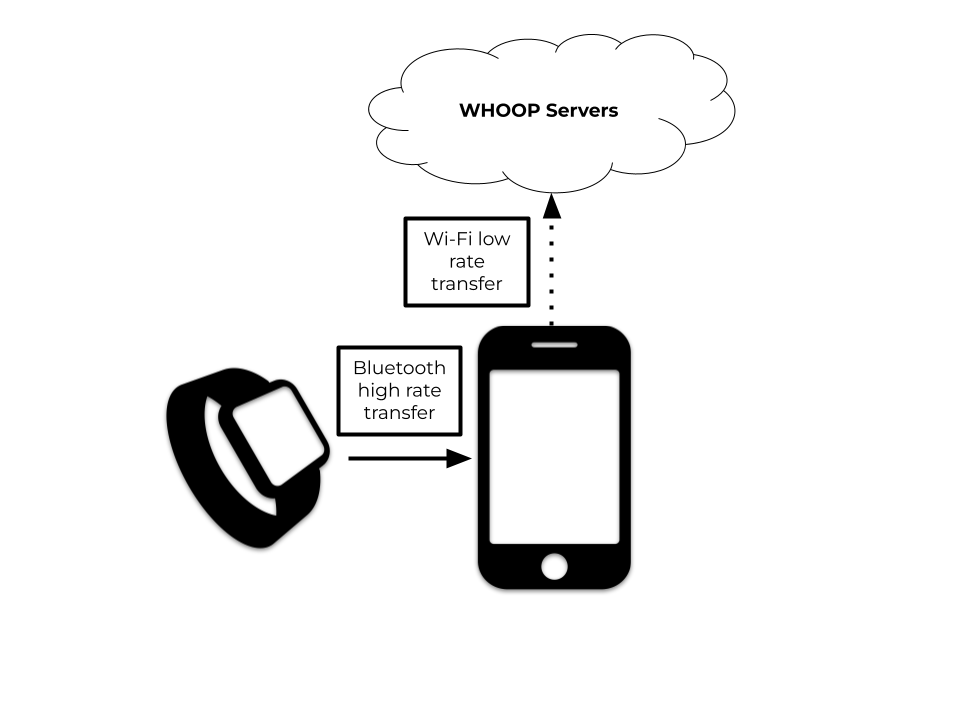


### How data is downloaded from WHOOP

To actually view data, the watch is not involved at all. Instead, the phone makes requests to WHOOP servers. The unofficial API aims to replicate these requests from your own computer.

![WHOOP Figure download.png](https://drive.google.com/uc?export=view&id=1SSzkL4Xz8JCux4aBdiRUQFI6_rkPzBer)

Unfortunately, the API is fairly locked down, so it only allows you to make requests for information that is directly displayed onto the app or web app. This means that, as far as we know, we cannot extract continuous skin temperature measurements, as an example. That being said, we can still extract quite a bit:

- Continuous all-day *heart rate* measurements (once every six seconds)
    - since many values can be derived from this (e.g. time slept, calories, heart rate variability, respiratory rate), heart rate is a pretty fundamental measurement that should be useful for many analyses
- Coarse statistics for *blood oxygen level* and *skin temperature*
    - the WHOOP 4.0 [does in fact](https://www.whoop.com/thelocker/whoop-4-0-vs-3-0-whats-new/) contain sensors that measure both of these, but unfortunately only summary statistics (mean, variation) about these measurements over the course of a given sleep cycle

<br><br>
Now let's extract!

Let's get some coarse statistics about every single sleep cycle you've had! You can also set custom start and end dates to get information only within that time range.

In [ ]:
user = WhoopUser(email, password)
user.SEED = 2
user.SEED = 17
#user = WhoopUser('', '')
#@title Enter start and end dates (in the format yyyy-mm-dd)

#set start and end dates - this will give you all the data from 2000-01-01 (January 1st, 2000) to 2100-02-03 (February 3rd, 2100), for example
startStr='2000-01-01' #@param {type:"string"}
endStr='2100-02-03' #@param {type:"string"}
# get cycle data from start to end
start_end ={
    'start': startStr+'T00:00:00.000Z',
    'end': endStr+'T00:00:00.000Z'
}

#show information for sleep cycles of interest 
cycles_df = user.get_cycles_df(params=start_end)

#gives summary statistics for various metrics
metrics_df = user.get_health_metrics_df(params=start_end)

This data provides a bird's eye view of your entire usage of the device. With `cycles_df` can see what your resting heart rate was for each day, your max heart rate for each day, and how much you slept each day (in milliseconds). With `metrics_df` you see other metrics (which are displayed under the "Health Monitor" tab in the phone app).

# 4. Data Visualization 
Let's plot how much sleep you have had, replicating the plot from the app...

<img src="https://imgur.com/jx5CmC3.png" width="400">

*Above is a plot from the app*

## 4.1 Plot Sleep

Here we use matplotlib to reproduce the plot above. There's a lot of code here, but we added comments to help guide your reading.

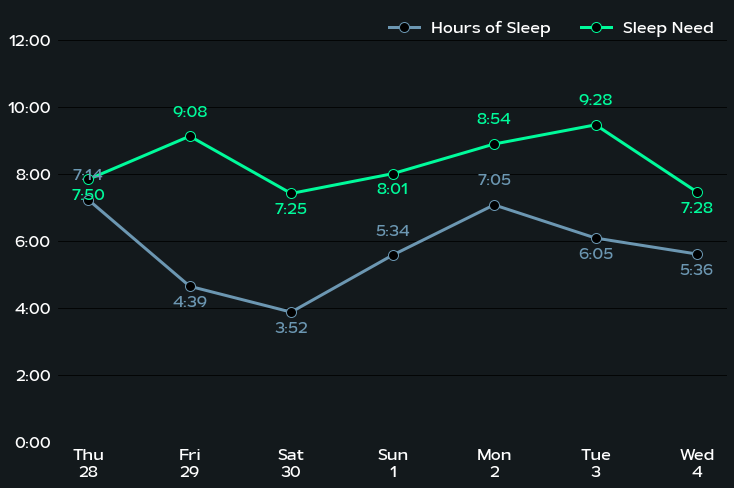

In [ ]:
#@title Plot sleep throughout the week
start_date = "2022-04-28" #@param {type:"date"}

start_idx = np.where(cycles_df.day == start_date)[0][0]


from scipy import interpolate
from datetime import datetime

# only plotting a week
PLOT_LENGTH = 7

# custom font
# https://stackoverflow.com/questions/35668219/how-to-set-up-a-custom-font-with-custom-path-to-matplotlib-global-font
# download the font and unzip (quiet so it does not print)
!wget -q 'https://dl.dafont.com/dl/?f=gymkhana'
!unzip -qo "index.html?f=gymkhana"

# move to directory where fonts should be kept
!mv gymkhana-bk.ttf /usr/share/fonts/truetype/

# build cache, redirect to /dev/null to suppress stdout output
!fc-cache -f -v > /dev/null

import matplotlib as mpl
import matplotlib.font_manager as fm

# try and except, just in case something fails we fallback onto the
# default font
try:
    fe = fm.FontEntry(
        #font name
        fname='/usr/share/fonts/truetype/gymkhana-bk.ttf',
        name='gymkhana')
    fm.fontManager.ttflist.insert(0, fe) # or append is fine
    mpl.rcParams['font.family'] = fe.name # = 'your custom ttf font name'
except:
    pass

weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

def ms_to_hm(ms):
    hours = int(ms / (60 * 60 * 1000))
    minutes = round((ms / (60 * 1000)) % 60)

    return hours, minutes

def ms_to_text(ms):
    hours, minutes = ms_to_hm(ms)

    return f'{hours:02}:{minutes:02}'

def determine_offset(i, values):
    """
    Takes in array-like values and an index for that array, then
    computes what offset the text annotation should have. Intuition
    is that text annotation should not collide with the lines.

    NOTE: We attempted to use https://github.com/Phlya/adjustText, but
    could not get it to work.
    """

    if i == 0:
        # put above if going down, otherwise below
        offset = (values[0] > values[1]) * 2 - 1
    elif i == sleep_dur.shape[0] - 1:
        # put above if going up, otherwise below
        offset = (values[i] > values[i - 1]) * 2 - 1
    elif values[i] < values[i+1] and values[i] < values[i-1]:
        # valley
        offset = -1
    elif values[i] > values[i+1] and values[i] > values[i-1]:
        # peak
        offset = 1
    elif values[i] > values[i+1] and values[i] < values[i-1]:
        # maintain same sign of slope (downwards)
        if values[i] - values[i+1] > values[i-1] - values[i]:
            offset = 1
        else:
            offset = -1
    elif values[i] < values[i+1] and values[i] > values[i-1]:
        # maintain same sign of slope (upwards)
        if values[i+1] - values[i] > values[i] - values[i-1]:
            offset = -1
        else:
            offset = 1
    
    return offset

def plot_line_fancy(X, Y, label, color=None):

    plt.plot(X, Y / (60 * 60 * 1000), marker='o', markerfacecolor='black',
             markeredgewidth=1, markersize=10, linewidth=3, label=label,
             color=color)

    # add text annotations
    for i, dur in enumerate(Y):
        offset = determine_offset(i, np.array(Y))
        plt.text(i, 0.6 * offset + dur / (60 * 60 * 1000), ms_to_text(dur).lstrip('0'),
                 ha='center', fontsize=15, color=color)

    # set to maximum y-value (in this case it is 12 hours)
    max_sleep_hours = 13
    plt.ylim(0, max_sleep_hours)

    # this function turns a string like '2022-04-28' into 'Thu\n28'
    def day_label_to_fig_label(day):
        weekday = weekdays[datetime.strptime(day, '%Y-%m-%d').weekday()]
        day_num = str(int(day.split('-')[-1]))

        return weekday + '\n' + day_num

    # set the labels on the left and bottom to match the app's plot
    plt.xticks(ticks=np.arange(PLOT_LENGTH),
               labels=[day_label_to_fig_label(day) for day in X],
               fontsize=15)

    plt.yticks(ticks = list(range(max_sleep_hours + 1))[::2],
               labels = [f'{i}:00' for i in range(max_sleep_hours + 1)][::2], 
               rotation = 'horizontal',fontweight='bold', fontsize=15)

    # get rid of the little tickmarks on the bottom and side
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True)

    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the left edge are off
        labelbottom=True)

with plt.style.context('dark_background'):
    sleep_dur = cycles_df.sleep_quality_duration.iloc[start_idx:start_idx+PLOT_LENGTH]
    sleep_need = cycles_df.sleep_need_total.iloc[start_idx:start_idx+PLOT_LENGTH]
    day = cycles_df.day.iloc[start_idx:start_idx+PLOT_LENGTH]

    # we'll use the same dark blue shade for the background color
    # throughout this plot
    background_color = '#13191C'

    # create the figure
    plt.figure(figsize=(12,8), facecolor=background_color)

    # plot both values over time
    plot_line_fancy(day, sleep_dur, 'Hours of Sleep', color='#6c97b2')
    plot_line_fancy(day, sleep_need, 'Sleep Need', color='#00fb9b')

    # insert legend
    plt.legend(facecolor=background_color,  # ensure same background color
               frameon=False,  # turn off boundaries
               ncol=2,  # arrange horizontally
               prop={'size': 15})  # set font size

    # get rid of the axis lines
    for d in ["left", "top", "bottom", "right"]:
        plt.gca().spines[d].set_visible(False)

    # set background color *inside the figure*
    plt.gca().set_facecolor(color=background_color)

    # add horizontal grid
    plt.gca().grid(False)
    plt.gca().grid(axis='y', color='black')

*Above is a plot we created ourselves!*

We can also dig into other statistics, such as skin temperature, taking advantage of that extra sensor. In fact, here we'll actually plot something you simply *cannot* see in the phone app nor web app! On the app, you can only see last night's skin temperature, but not previous night's skin temperature. Here, we'll plot the skin temperature the same week's sleep cycles.

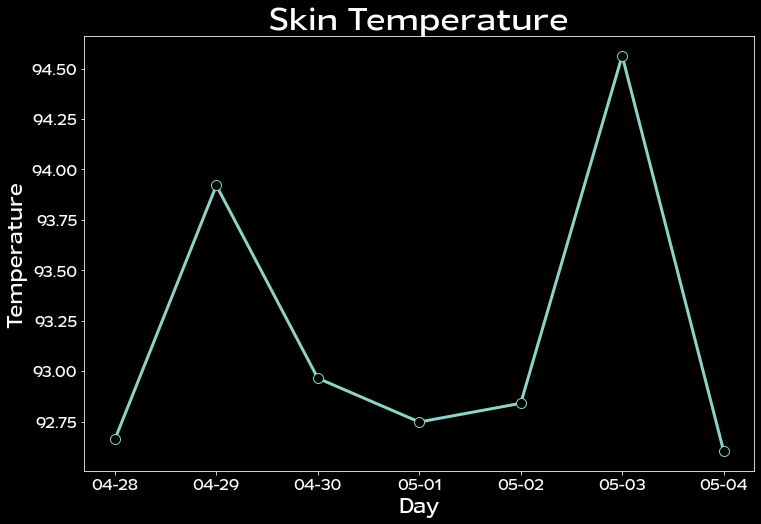

In [ ]:
#@title Skin Temperature Plot
start_date = "2022-04-28" #@param {type:"date"}

start_idx = np.where(metrics_df.day == start_date)[0][0]


with plt.style.context('dark_background'):
    #start_idx = 2
    temps = metrics_df['SKIN_TEMPERATURE_FAHRENHEIT.current_value'].iloc[start_idx:start_idx+7]
    day = metrics_df.day.iloc[start_idx:start_idx+7]

    plt.figure(figsize=(12,8))

    plt.plot(day, temps, marker='o', markerfacecolor='black',
             markeredgewidth=1, markersize=10, linewidth=3)

    plt.title('Skin Temperature', fontsize=30)
    plt.ylabel('Temperature', fontsize=20)
    plt.xlabel('Day', fontsize=20)

    plt.yticks(fontsize=15)
    plt.xticks(ticks=day, labels=['-'.join(d.split('-')[1:]) for d in day], fontsize=15)

# 4.2 Plot Heart Rate

Now let's dig a little deeper and look at our raw heart rate data! Let's get all of our heart rate data in the week 04-28 to 05-05. Feel free to change this to some other week of your choosing!

Also, specify the timezone for which you were using this device (see [this list](https://en.wikipedia.org/wiki/List_of_tz_database_time_zones) for exact strings, under the column `TZ database name`).

In [ ]:
#@title Set date range and timezone
start = "2022-04-28" #@param {type:"date"}
end = "2022-05-05" #@param {type:"date"}
timezone = "US/Pacific" #@param {type:"string"}
params = {
    'start': f'{start}T00:00:00.000Z',
    'end': f'{end}T00:00:00.000Z'
}

We'll use our WhoopUser class that we already initialized to extract the heart rate data first.

In [ ]:
hr_df = user.get_heart_rate_df(params=params, timezone=timezone)

/content/whoop_user.py:223: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  hr_df_syn = pd.DataFrame(pd.np.empty((N, 2)) * pd.np.nan, columns=['heart_rate', 'timestamp'])
100%|██████████| 275000/275000 [00:17<00:00, 16070.07it/s]
43it [00:00, 294.60it/s]
100%|██████████| 275000/275000 [00:13<00:00, 20977.43it/s]


Let's see what `hr_df` contains in its raw form.

In [ ]:
hr_df

,heart_rate,timestamp
24686,71,2022-04-27 17:00:02-07:00
24687,62,2022-04-27 17:00:09-07:00
24688,98,2022-04-27 17:00:16-07:00
24689,72,2022-04-27 17:00:23-07:00
24690,59,2022-04-27 17:00:30-07:00
...,...,...
111081,78,2022-05-04 16:59:27-07:00
111082,89,2022-05-04 16:59:34-07:00
111083,78,2022-05-04 16:59:41-07:00
111084,73,2022-05-04 16:59:48-07:00


Now let's try to reproduce the heart rate line graph from the app, as shown below.

<img src="https://imgur.com/CXGhjJa.png" width="900">

*Above is a plot from the app*

First, to satiate our curiosity, let's just see what the heart rate graph looks like for the entire week...

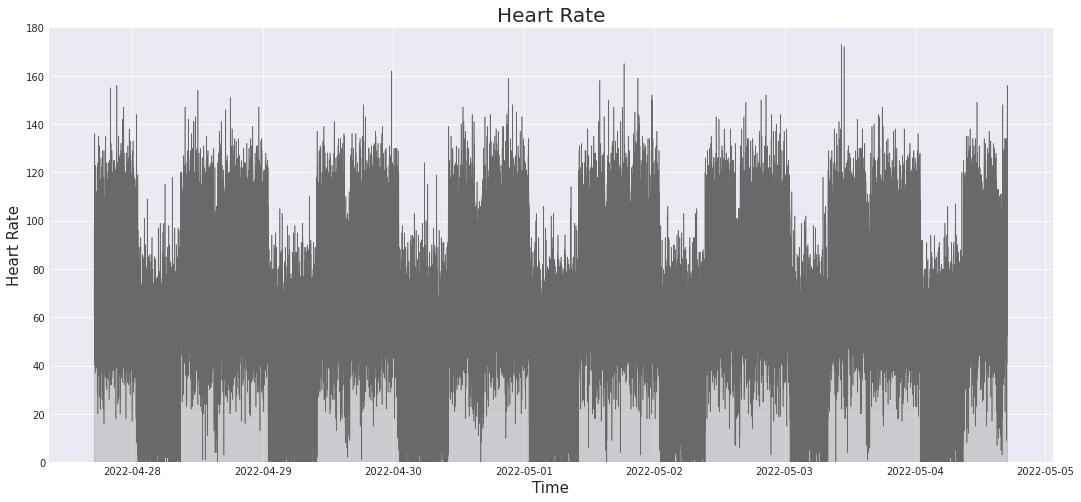

In [ ]:
with plt.style.context('seaborn-darkgrid'):

    plt.figure(figsize=(18,8))

    plt.title('Heart Rate', fontsize=20)

    plt.plot(hr_df.timestamp, hr_df.heart_rate, linewidth=0.5, color='dimgrey')
    plt.fill_between(hr_df.timestamp, hr_df.heart_rate, color='grey', alpha=0.3)

    plt.ylim(0, 180)
    plt.ylabel('Heart Rate', fontsize=15)
    plt.xlabel('Time', fontsize=15)

Great! We can see some periodic patterns arise! Let's do some simple Gaussian smoothing to try to see what these patterns really are. We use the [`gaussian_filter` method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html) from SciPy for this.

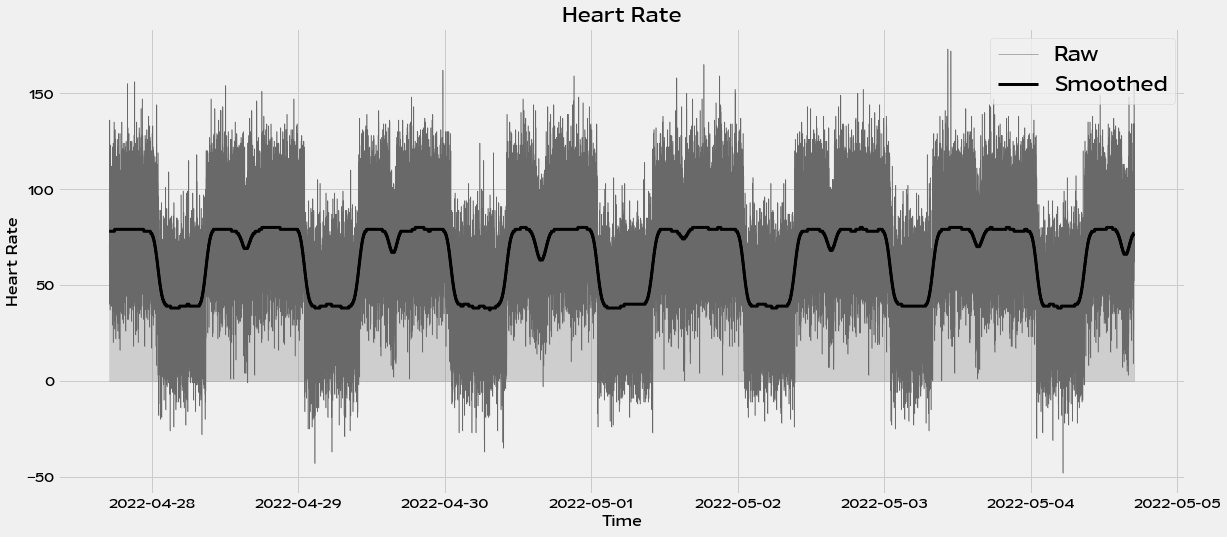

In [ ]:
stdev_minutes = 30
# multiply by 60 to get stdev_seconds, then divide by 6 to get
# this in units of measurements (once every six seconds)
stdev = stdev_minutes * 60 / 6

with plt.style.context('fivethirtyeight'):

    plt.figure(figsize=(18,8))

    plt.title('Heart Rate', fontsize=20)

    plt.plot(hr_df.timestamp, hr_df.heart_rate, linewidth=0.5, color='dimgrey', label='Raw')
    plt.fill_between(hr_df.timestamp, hr_df.heart_rate, color='grey', alpha=0.3)

    plt.plot(hr_df.timestamp, gaussian_filter(np.array(hr_df.heart_rate), sigma=stdev), linewidth=3, color='black', label='Smoothed')

    plt.ylabel('Heart Rate', fontsize=15)
    plt.xlabel('Time', fontsize=15)
    plt.legend(prop={'size': 20})

Now let's get back to trying to reproduce the specific plot we see in the app. While the plotting code is long (which is necessary to reproduce as close as possible), it has lots of comments to guide you through what each component does, if you want to adapt it for your own usage. Regardless, here are some high-level pointers:

- We define gaps (when the user takes off the device) as any space between measurements that exceeds 12 seconds. To find the gaps, we compute the consecutive pairwise differences between measurement timestamps, and find where the difference exceeds 12 seconds.
- `plt.fill_between` and `plt.plot` are ordered in such a way that subsequent ones are *overlayed* ontop of the previous ones, allowing us to worry less about iterating through in the right way from left to right and instead just plotting waking hours, sleep hours, and gaps completely separately.
- For some weird reason, when requesting cycles or sleep data, the API does not care about time, only date. Since both sleeps are on the same day (in the UTC timezone), we just have to request one day of sleep information, and the time is arbitrary for both parameters fed into `user.get_sleeps_df()`.

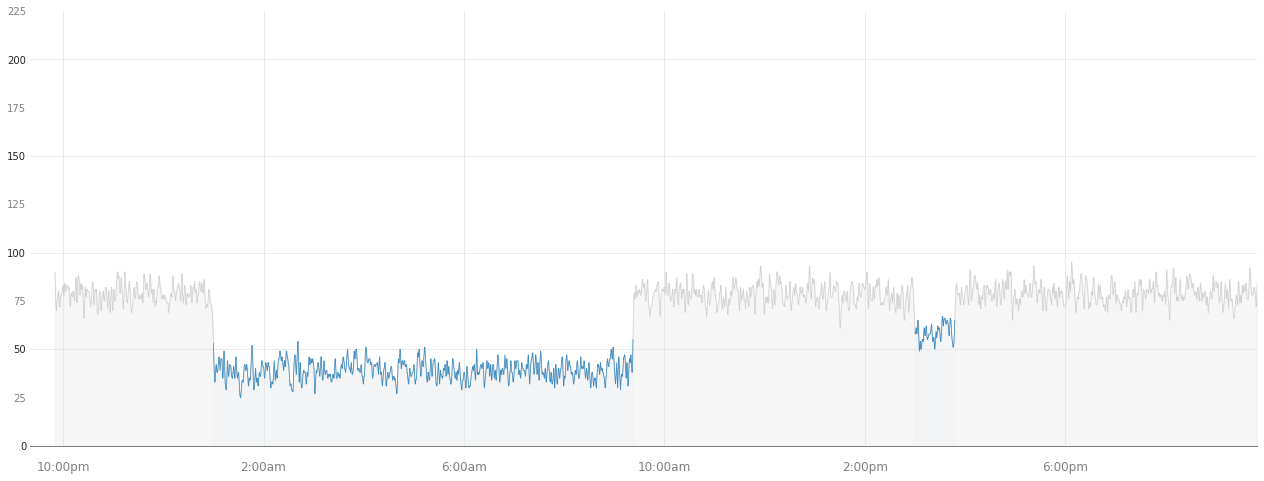

In [ ]:
#@title Reproduce 24 hour heart rate plot
from matplotlib.ticker import FormatStrFormatter
from dateutil import tz
import datetime

# measurements are taken every six seconds
HEART_RATE_RECORDING_LENGTH = 6

day_num = 1

params_day = {
    'start': f'2022-05-{str(day_num+1).zfill(2)} T00:00:00.000Z',
    'end': f'2022-05-{str(day_num+1).zfill(2)} T23:00:00.000Z'  # arbitrary time choice
}

sleeps = user.get_sleeps_df(params=params_day, timezone='US/Pacific')
from datetime import datetime

stdev_minutes = .5
# multiply by 60 to get stdev_seconds, then divide by 6 to get
# this in units of measurements (once every six seconds)
stdev = stdev_minutes * 60 / 6

with plt.style.context('seaborn-darkgrid'):
    # get the start and end times as timestamps by using the datetime library
    start_ts = datetime.strptime(f'2022-05-{str(day_num).zfill(2)} 21:50:00-07:00', '%Y-%m-%d %H:%M:%S%z').timestamp()
    end_ts = datetime.strptime(f'2022-05-{str(day_num+1).zfill(2)} 21:50:00-07:00', '%Y-%m-%d %H:%M:%S%z').timestamp()

    # now find the indices in hr_df.timestamp that match as closely as possible
    start_idx = np.argmin(np.abs(hr_df.timestamp.apply(lambda x: x.timestamp()) - start_ts))
    end_idx = np.argmin(np.abs(hr_df.timestamp.apply(lambda x: x.timestamp()) - end_ts))

    x = np.array(hr_df.timestamp.iloc[start_idx:end_idx])
    y = hr_df.heart_rate.iloc[start_idx:end_idx]

    # make it not as bumpy with gaussian filter
    y = gaussian_filter(y, sigma=stdev)

    plt.figure(figsize=(22,8), facecolor='white')

    x_timestamp = np.array([x_.timestamp() for x_ in x])

    # get the gaps. we include [6] as well because when you do np.diff,
    # it actually leaves out exactly one element
    differences = np.concatenate((np.diff(x_timestamp), [6]))

    # interpret a gap (i.e. when a user takes off the device for some prolonged
    # period of time) as any two measurements that are taken more than
    # 6 * 2 = 12 seconds apart, to account for minor variations around 6s
    gap_idxes = np.where(differences > HEART_RATE_RECORDING_LENGTH * 2)[0]

    # get the sleeps
    sleep_idxes = []
    for lower, upper in zip(sleeps.time_lower_bound, sleeps.time_upper_bound):
        # get the location in the timestamp array that is closest to `lower`
        lower_idx = np.argmin(np.abs((x_timestamp - lower.timestamp()) - 0))
        # get the location in the timestamp array that is closest to `upper`
        upper_idx = np.argmin(np.abs((x_timestamp - upper.timestamp()) - 0))

        sleep_idxes.append((lower_idx, upper_idx))

    # fill in the area under the curve with different colors depending
    # on whether it is a gap or a sleep

    # first, we just plot the entire thing
    plt.plot(x, y, linewidth=0.75, color='#d1d1d1')
    plt.fill_between(x, y, color='#e3e3e3', alpha=0.3)

    # now we overlay sleeps
    for sleep_start, sleep_end in sleep_idxes:
        plt.plot(x[sleep_start:sleep_end], y[sleep_start:sleep_end], linewidth=0.75, color='#3f8fc5')
        if sleep_start >= sleep_end:
            continue

        plt.fill_between(x[sleep_start:sleep_end], y[sleep_start:sleep_end], color='#eaf1f6', alpha=0.3)

    # now we overlay gaps by overlaying with white
    for gap_idx in gap_idxes:
        plt.plot(x[gap_idx-2:gap_idx+2], y[gap_idx-2:gap_idx+2], linewidth=1, color='white')
        plt.fill_between(x[gap_idx-2:gap_idx+2], y[gap_idx-100:gap_idx+100].max(), color='white')

    plt.ylim(0, 225)
    plt.xlim(x[0] - pd.Timedelta(minutes=30), x[-1])

    # set the x ticks to be every 4 hours, just like the app's plot
    datetimes = [
        datetime.strptime(f'2022-05-{str(day_num).zfill(2)} 22:00:00-0700', '%Y-%m-%d %H:%M:%S%z'),
        datetime.strptime(f'2022-05-{str(day_num+1).zfill(2)} 02:00:00-0700', '%Y-%m-%d %H:%M:%S%z'),
        datetime.strptime(f'2022-05-{str(day_num+1).zfill(2)} 06:00:00-0700', '%Y-%m-%d %H:%M:%S%z'),
        datetime.strptime(f'2022-05-{str(day_num+1).zfill(2)} 10:00:00-0700', '%Y-%m-%d %H:%M:%S%z'),
        datetime.strptime(f'2022-05-{str(day_num+1).zfill(2)} 14:00:00-0700', '%Y-%m-%d %H:%M:%S%z'),
        datetime.strptime(f'2022-05-{str(day_num+1).zfill(2)} 18:00:00-0700', '%Y-%m-%d %H:%M:%S%z')
    ]

    plt.xticks(ticks=datetimes,
               labels=['10:00pm', '2:00am', '6:00am', '10:00am', '2:00pm', '6:00pm'],
               fontsize=12,
               color='grey')
    
    # ensure that the bottom labels are padded
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        pad=15)

    # set y ticks so that they are major and minor, so that we can have gridlines
    # on a larger interval
    plt.gca().set_yticks(np.arange(0, 250, 25)[::2], minor=False)
    plt.gca().set_yticks(np.arange(0, 250, 25)[1::2], minor=True)
    plt.gca().yaxis.set_minor_formatter(FormatStrFormatter("%d"))

    # get rid of the ticks for the y-axis
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='minor',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        labelcolor='grey')

    # set background color *inside the figure*
    plt.gca().set_facecolor(color='white')

    # add horizontal grid
    plt.gca().grid(axis='x', color='#e5e5e5')
    plt.gca().grid(axis='y', color='#e5e5e5', which='major')

    # ensure the bottom axis is slightly darker and extends all the way
    # to the left
    plt.gca().spines['bottom'].set_edgecolor('grey')
    plt.gca().spines['bottom'].set_linewidth(1)
    plt.gca().spines['bottom'].set_visible(True)

*Above is a plot we created ourselves!*

As you can see, we are able to reproduce not only just the heart rate over time, but also when the heart rate is not recorded, and also when the user goes to sleep, either for a night sleep or for a nap.

# 5. Data Analysis

Data isn't much without some analysis, so we're going to do some in this section.

DISCLAIMER: the analyses below may not be 100% biologically or scientifically grounded; the code is here to assist in your process, if you are interested in asking these kinds of questions.

## 5.1 Heart rate vs. sleep period length
Maybe the heart rate is correlated with how long a particular sleep period was. Let's see if this hypothesis is true. First, we get all sleeps. We just give a time period from 2020 until May 29nd, 2022, because that'll catch everything for this user up until the time this notebook and the associated analyses below were run (so that our analysis results stay the same).

In [ ]:
#@title Set date range and timezone
start = "2020-01-01" #@param {type:"date"}
end = "2022-05-22" #@param {type:"date"}
timezone = "US/Pacific" #@param {type:"string"}
params_all = {
    'start': f'{start}T00:00:00.000Z',
    'end': f'{end}T00:00:00.000Z'
}

In [ ]:
sleeps = user.get_sleeps_df(params=params_all, timezone=timezone)
sleeps

,cycle_id,sleep_id,cycles_count,disturbance_count,time_upper_bound,time_lower_bound,is_nap,in_bed_duration,light_sleep_duration,latency_duration,no_data_duration,rem_sleep_duration,respiratory_rate,sleep_score,sleep_efficiency,sleep_consistency,sws_duration,wake_duration,quality_duration
0,786,831,1,14,2022-04-26 09:17:57-07:00,2022-04-26 01:00:00-07:00,False,8.299187,4.149593,0,0,0.829919,16.034276,50,0.9,0.374207,2.489756,0.829919,7.469268
1,499,877,0,14,2022-04-26 15:28:26-07:00,2022-04-26 15:00:00-07:00,True,0.474137,0.237069,0,0,0.047414,15.175261,69,0.9,0.373756,0.142241,0.047414,0.426724
2,930,331,0,7,2022-04-27 09:27:38-07:00,2022-04-27 01:00:00-07:00,False,8.460614,4.230307,0,0,0.846061,15.849114,43,0.9,0.352968,2.538184,0.846061,7.614553
3,217,598,1,20,2022-04-27 15:53:37-07:00,2022-04-27 15:00:00-07:00,True,0.893689,0.446844,0,0,0.089369,14.577023,42,0.9,0.544819,0.268107,0.089369,0.804320
4,803,117,2,7,2022-04-28 08:50:54-07:00,2022-04-28 01:00:00-07:00,False,7.848470,3.924235,0,0,0.784847,14.036402,61,0.9,0.383946,2.354541,0.784847,7.063623
5,69,365,0,23,2022-04-28 15:47:20-07:00,2022-04-28 15:00:00-07:00,True,0.789084,0.394542,0,0,0.078908,15.380196,44,0.9,0.425368,0.236725,0.078908,0.710176
6,810,354,3,9,2022-04-29 09:53:54-07:00,2022-04-29 01:00:00-07:00,False,8.898347,4.449174,0,0,0.889835,14.627758,89,0.9,0.609418,2.669504,0.889835,8.008512
7,98,51,2,12,2022-04-29 15:59:27-07:00,2022-04-29 15:00:00-07:00,True,0.990975,0.495487,0,0,0.099097,15.436805,35,0.9,0.809198,0.297292,0.099097,0.891877
8,983,848,2,11,2022-04-30 10:07:15-07:00,2022-04-30 01:00:00-07:00,False,9.120842,4.560421,0,0,0.912084,16.163113,98,0.9,0.355837,2.736253,0.912084,8.208758
9,78,6,2,13,2022-04-30 16:36:27-07:00,2022-04-30 15:00:00-07:00,True,1.607619,0.803809,0,0,0.160762,15.308161,68,0.9,0.252681,0.482286,0.160762,1.446857


Then, let's get the heart rate over time for each sleep. Note that requesting all of the heart rate data will take just a bit of time, depending on how many weeks we have to request data for. We'll use the `verbose` parameter to ensure that we maintain our sanity as we wait for it to complete.

In [ ]:
hr_df = user.get_heart_rate_df(params_all, timezone='US/Pacific', verbose=True)

100%|██████████| 275000/275000 [00:13<00:00, 20516.82it/s]


Now let's take this raw heart rate data over the course of several weeks and analyze it against sleep.

In [ ]:
heart_rates = []
lengths = []

for lower, upper in zip(sleeps.time_lower_bound, sleeps.time_upper_bound):
    heart_rate = np.array(hr_df[np.logical_and(lower < hr_df.timestamp, hr_df.timestamp < upper)].heart_rate)
    length = (upper - lower).seconds / 3600  # hours

    heart_rates.append(heart_rate)
    lengths.append(length)

sleeps['length_in_hours'] = np.array(lengths)
sleeps['median_heart_rate'] = np.array([np.median(hr) for hr in heart_rates])  # median heart rates

Let's make a quick plot to get some intuition. Here we just use [seaborn](https://seaborn.pydata.org/), as it's very quick to get beautiful plots out with minimal effort.

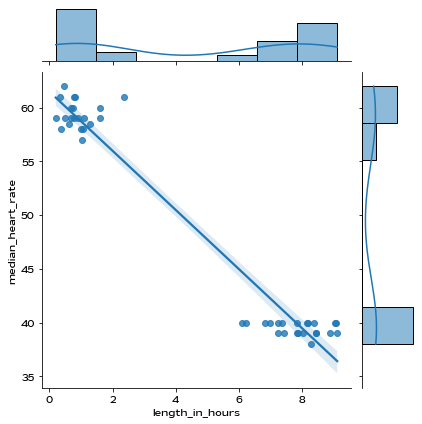

In [ ]:
p = sns.jointplot(x='length_in_hours', y='median_heart_rate', data=sleeps, kind='reg')

As we can see from the scatterplot above, it looks like there might be a correlation there. Let's compute $R^2$ just to see exactly how correlated.

We'll follow [this documentation](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.linregress.html) and perform a linear regression to obtain the coefficient of determination.

In [ ]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(sleeps['length_in_hours'], sleeps['median_heart_rate'])

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: -2.75
Coefficient of determination: 0.957
p-value: 1.4e-29


We also see that the p-value, which is determined by scipy to be the two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, is significant ($<$0.05).

So given this evidence from this particular data, maybe length of a sleep period is correlated with your heart rate.

However, let's suppose there was an anomaly in the heart rate (such as due to a measurement error or device failure) that skewed our results, such as below:

In [ ]:
sleeps.loc[1, ['median_heart_rate']] = 800

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(sleeps['length_in_hours'], sleeps['median_heart_rate'])

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: -8.17
Coefficient of determination: 0.0653
p-value: 0.098


We see that if we perform the same p-value analysis as done before, we get that the p-value is not significant.

Let's implement a system that assumes the data was sampled according to a multivariate normal distribution to automatically detect and remove outliers like this, based on the method described [here](https://medium.com/analytics-vidhya/outlier-detection-with-multivariate-normal-distribution-in-python-480033ba3a8a).

Warning: anomaly/outlier detection is done just to show an example of data processing that can be done and may hide genuine values that have clinical significance. Use at your own risk.


[4.73888889e-01 8.00000000e+02]  is an Outlier
1


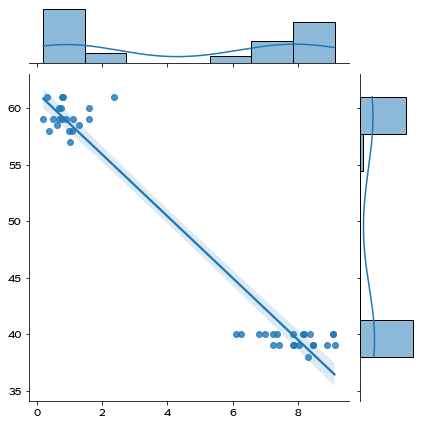

In [ ]:
from scipy.stats import multivariate_normal
#calculate the covariance matrix
data = np.stack((sleeps['length_in_hours'],sleeps['median_heart_rate']),axis=0)
covariance_matrix = np.cov(data)

#calculating the mean
mean_values = [np.mean(sleeps['length_in_hours']),np.mean(sleeps['median_heart_rate'])]

#multivariate normal distribution
model = multivariate_normal(cov=covariance_matrix,mean=mean_values)
data = np.stack((sleeps['length_in_hours'],sleeps['median_heart_rate']),axis=1)

#finding the outliers

#any point with a probability lower than the threshold value is considered an outlier and removed 
threshold = 1.0e-07
outlier = model.pdf(data).reshape(-1) < threshold

newData=data
outlierValues=[]
for boolean,i in enumerate(outlier):
  if i == True:
    print(data[boolean]," is an Outlier")
    print(np.where(data==(data[boolean])[0])[0].item(0))
    #delete outliers
    newData=np.delete(newData,np.where(newData==(data[boolean])[0])[0].item(0),axis=0)

#plot new graph with outliers removed
#newData[:,0] correspond to the new lengths, and newData[:,1] correspond to the new values
p = sns.jointplot(x=newData[:,0], y=newData[:,1], kind='reg')

Now let's perform a linear regression again to see how this affects our results.

In [ ]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(newData[:,0], [np.median(hr) for hr in newData[:,1]])

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: -2.73
Coefficient of determination: 0.956
p-value: 1.03e-28


With the outlier removed, we can see that our results are return to statistical significance!

## 5.2: Heart rate vs. nap or sleep

Now we'll look at whether the median heart rate changes depending on whether you are napping or sleeping.

We've already extracted the heart rate time series data for each sleep, so now all we need to do is just get `is_nap` column.

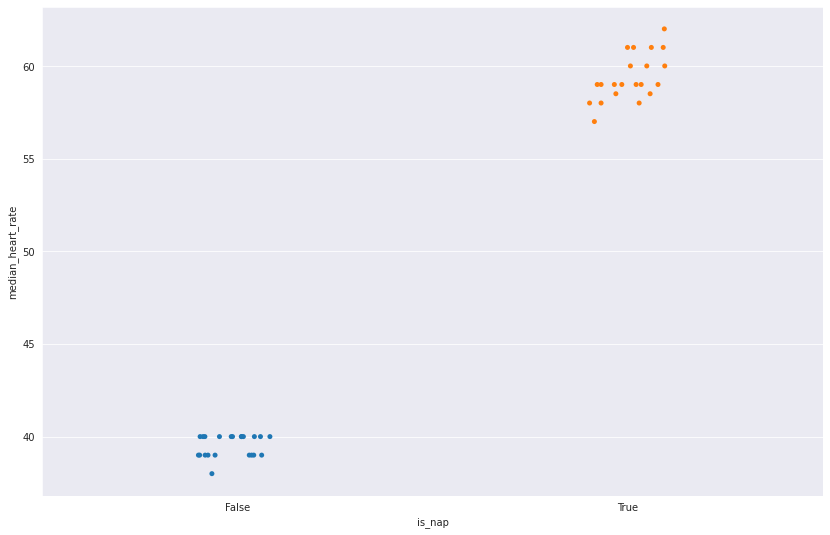

In [ ]:
plt.figure(figsize=(14,9))
sns.set_style('darkgrid')

# just return the sleeps dataframe back to normal
sleeps.loc[1, ['median_heart_rate']] = 62

sns.stripplot(x='is_nap',y='median_heart_rate', data=sleeps)

In the plot above, we do see that the heart rate does seem to vary a bit depending on whether the user is napping or not. Here, we see that when the the sleep is marked as a nap (whether by the user or automatic detection, [depending on when it occurs during the day](https://support.whoop.com/WHOOP_Data/Activities__Auto-Detection/Sleep_Auto-Detection)), we tend to get a median heart rate higher than otherwise.

Note: WHOOP calculates hours of sleep without including naps, [while sleep need is calculated with naps taken into account](https://www.whoop.com/thelocker/how-long-should-you-nap/).

Let's do a T-test to see if the difference in heart rate is significant.

In [ ]:
result = stats.ttest_ind(sleeps.median_heart_rate[sleeps.is_nap == True],
                         sleeps.median_heart_rate[sleeps.is_nap == False])

print(f'P-value is {result.pvalue:.3g}')

P-value is 2.94e-43


Looks significant (<0.05)!